In [1]:
## THIS IS THE SAME AS PRECIP_&_COLDCORE_SINGLE_CELL_LOOP.IPYNB BUT FOR THE PRESENT DAY AND FUTURE SIMULATIONS (THAT HAVE A 360 DAY CALENDAR AND SO CAN'T USE NP.DATETIME64) ##

import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure
import cftime

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [92]:
# Import datasets
#mask = xr.open_dataset('/data/users/hgilmour/initial_tracks/tobac_initial_tracks/segmentation/regridded/regridded_segmentation_yearly_1998.nc')
mask = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/segmentation/regridded/regridded_segmentation_yearly_2002.nc')
mask = mask.segmentation_mask
mask #segmentation mask from tracking on Jan 2005 with [240, 200] and [1975, 10]

#precip = xr.open_dataset('/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_1998.nc')
precip = xr.open_dataset('/scratch/hgilmour/cpm_PD/total_precip/annual_files/regridded/regridded_total_precip_2002.nc')
precip = precip.unknown #precip dataset for Jan 2005 (NEED TO LATER CONVERT FROM KG M-2 S-1 TO MM/HR (X3600))

tracks = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_PD_TRACKS/init_tracks/tracks_2002.h5', 'table')

#tb = xr.open_dataset('/data/users/hgilmour/tb/regridded/regridded_tb_1998.nc')
tb = xr.open_dataset('/scratch/hgilmour/cpm_PD/tb/annual_files_hrly/regridded/regridded_tb_2002.nc')
tb = tb.toa_outgoing_longwave_flux

#vert_vel = xr.open_dataset('/scratch/hgilmour/omega_new/regridded/regridded_omega_1998.nc')
vert_vel = xr.open_dataset('/scratch/hgilmour/cpm_PD/omega/annual_files/regridded/regridded_omega_2002.nc')
#vert_vel = vert_vel.dz_dt
vert_vel = vert_vel.dz_dt
vert_vel = vert_vel[:,:,:] # making sure there are 1360 latitudes rather than 1361


In [93]:
#tracks = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/final_tracks_CPM_REGRIDDED/merged/all_years_combined_CCPF/all_years_CCPF_cpm_hindcast.hdf', 'table')

In [94]:
precip

<xarray.DataArray 'unknown' (time: 8640, latitude: 550, longitude: 550)>
[2613600000 values with dtype=float32]
Coordinates:
  * time       (time) object 2002-01-01 00:30:00 ... 2002-12-30 23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -84.95 -84.85 -84.75 ... -30.25 -30.15 -30.05
Attributes:
    grid_mapping:  latitude_longitude

In [95]:
#tracks[tracks.cell == 200213553]

In [96]:
mask.shape == precip.shape # checking whether the mask and precip files have the same shape
# next steps won't work if not


True

In [97]:
# Copy tracks dataset into new tracks_precip dataset to append precip data to
tracks = tracks.copy()

In [98]:
# Add columns to the tracks_precip dataframe ready to append data to later
tracks['total_precip'] = 0 #total precip from any precipitating pixel
tracks['rain_flag'] = 0 # total number of pixels that meet the 1mm/hr threshold
tracks['light_precip'] = 0 # total rain from all pixels where the rainfall threshold of 1 mm/hr is met
tracks['heavy_precip'] = 0 # total rain from all pixels where the heavy rainfall threshold of 10 mm/hr is met
tracks['extreme_precip'] = 0 # total rain from all pixels where the extreme rainfall threshold of 50 mm/hr is met
tracks['max_precip'] = 0 # maximum rainfall rate found over the masked area at that timstep
tracks['mean_precip_total'] = 0 # mean rainfall rate found over whole masked area (including non rainy pixels)

tracks['mean_precip'] = 0 # mean rainfall rate found over pixels that meet the precipitation threshold (> 1 mm/hr)


# Add cold core filter columns
tracks['tb_min'] = 0
tracks['tb_mean'] = 0
tracks['cold_core_flag'] = 0
tracks['tb_210'] = 0
tracks['tb_200'] = 0
tracks['tb_190'] = 0

# Add columns for vertical velocity (w)
tracks['w_max'] = float('NaN') # maximum vertical velocity
tracks['w_mean'] = float('NaN') # mean vertical velocity
tracks['w_mean_up'] = float('NaN') # mean vertical velocity of only positive values (i.e. upward motion)

# Add column for datetime
#tracks['cf_time'] = 0

# Add columns for latitude and longitude of variable maxima / minima
tracks['max_precip_lat'] = 0
tracks['max_precip_lon'] = 0
tracks['min_tb_lat'] = 0
tracks['min_tb_lon'] = 0
tracks['max_w_up_lat'] = 0
tracks['max_w_up_lon'] = 0
tracks['max_w_down_lat'] = 0
tracks['max_w_down_lon'] = 0


# # Add columns for colocated pixels of cold core <= 200K and precip > 1mm/hr
tracks['colocated_pixels'] = 0


In [99]:
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
0,0,4,156.190974,1298.073334,3160,240,1,2002-01-01 00:30:00,2002-01-01 00:30:00,-33.714315,-32.467977,-1,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
1,0,7,261.748255,1137.182655,3988,240,2,2002-01-01 00:30:00,2002-01-01 00:30:00,-29.439246,-38.984058,2,0 days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
2,0,27,429.849154,1035.934928,2044,240,3,2002-01-01 00:30:00,2002-01-01 00:30:00,-22.631159,-43.084575,-1,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
3,0,92,774.999926,351.434028,48395,240,4,2002-01-01 00:30:00,2002-01-01 00:30:00,-8.652553,-70.806873,4,0 days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
4,0,105,700.380842,781.032479,4186,240,5,2002-01-01 00:30:00,2002-01-01 00:30:00,-11.674626,-53.408139,-1,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103511,8639,276,954.533816,1037.245964,2097,240,103512,2002-12-30 23:30:00,2002-12-30 23:30:00,-1.381430,-43.031482,-1,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103512,8639,282,936.638329,997.860064,2132,240,103513,2002-12-30 23:30:00,2002-12-30 23:30:00,-2.106197,-44.626608,-1,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103513,8639,287,927.214027,925.971052,2393,240,103514,2002-12-30 23:30:00,2002-12-30 23:30:00,-2.487883,-47.538129,-1,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103514,8639,293,951.563449,419.417249,2782,240,103515,2002-12-30 23:30:00,2002-12-30 23:30:00,-1.501731,-68.053537,-1,NaT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


In [100]:
# remove cell values with -1 from tracks dataset
tracks = tracks[tracks.cell >= 0]
tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
1,0,7,261.748255,1137.182655,3988,240,2,2002-01-01 00:30:00,2002-01-01 00:30:00,-29.439246,-38.984058,2,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
3,0,92,774.999926,351.434028,48395,240,4,2002-01-01 00:30:00,2002-01-01 00:30:00,-8.652553,-70.806873,4,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
12,0,257,1052.841853,422.668567,7832,240,13,2002-01-01 00:30:00,2002-01-01 00:30:00,2.600044,-67.921869,13,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
13,0,274,1184.705593,1280.615834,15050,240,14,2002-01-01 00:30:00,2002-01-01 00:30:00,7.940526,-33.175012,14,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
14,0,286,1218.191526,111.457056,15913,240,15,2002-01-01 00:30:00,2002-01-01 00:30:00,9.296705,-80.525924,15,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103471,8637,155,746.982376,467.921621,12909,240,103472,2002-12-30 21:30:00,2002-12-30 21:30:00,-9.787264,-66.089112,23208,0 days 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103483,8638,45,428.399998,1223.951927,5234,240,103484,2002-12-30 22:30:00,2002-12-30 22:30:00,-22.689851,-35.469903,23144,1 days 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103488,8638,152,722.318706,771.086668,10591,240,103489,2002-12-30 22:30:00,2002-12-30 22:30:00,-10.786143,-53.810943,23212,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103503,8639,51,442.971425,1189.701379,2133,240,103504,2002-12-30 23:30:00,2002-12-30 23:30:00,-22.099708,-36.857033,23144,1 days 13:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


In [101]:
tracks.rename(columns={'projection_x_coordinate': 'longitude', 'projection_y_coordinate': 'latitude'}, inplace=True)
#tracks.longitude = tracks.longitude - 360

In [102]:
tracks.longitude

1        -38.984058
3        -70.806873
12       -67.921869
13       -33.175012
14       -80.525924
            ...    
103471   -66.089112
103483   -35.469903
103488   -53.810943
103503   -36.857033
103506   -54.584646
Name: longitude, Length: 59786, dtype: float64

In [103]:
pd.set_option("display.max_columns", 50)


In [104]:
tracks.cell

1             2
3             4
12           13
13           14
14           15
          ...  
103471    23208
103483    23144
103488    23212
103503    23144
103506    23212
Name: cell, Length: 59786, dtype: int64

In [105]:
tracks[tracks.cell == 23208]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
103371,8625,54,764.764254,422.283819,26348,240,103372,2002-12-30 09:30:00,2002-12-30 09:30:00,-9.067098,-67.937450,23208,0 days 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103377,8626,53,761.302768,424.014983,26315,240,103378,2002-12-30 10:30:00,2002-12-30 10:30:00,-9.207289,-67.867344,23208,0 days 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103383,8627,50,757.537561,426.506466,26419,240,103384,2002-12-30 11:30:00,2002-12-30 11:30:00,-9.359779,-67.766447,23208,0 days 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103389,8628,59,763.704942,467.279169,18595,240,103390,2002-12-30 12:30:00,2002-12-30 12:30:00,-9.110001,-66.115129,23208,0 days 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103396,8629,64,754.739517,470.975164,16124,240,103397,2002-12-30 13:30:00,2002-12-30 13:30:00,-9.473100,-65.965453,23208,0 days 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103403,8630,78,750.724918,467.311225,12591,240,103404,2002-12-30 14:30:00,2002-12-30 14:30:00,-9.635691,-66.113831,23208,0 days 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103410,8631,98,736.854456,462.113922,12823,240,103411,2002-12-30 15:30:00,2002-12-30 15:30:00,-10.197446,-66.324335,23208,0 days 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103418,8632,114,728.118697,456.837050,14175,240,103419,2002-12-30 16:30:00,2002-12-30 16:30:00,-10.551244,-66.538037,23208,0 days 07:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103424,8633,147,722.185281,457.989055,15388,240,103425,2002-12-30 17:30:00,2002-12-30 17:30:00,-10.791547,-66.491380,23208,0 days 08:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
103432,8634,152,712.997160,464.094598,14295,240,103433,2002-12-30 18:30:00,2002-12-30 18:30:00,-11.163666,-66.244124,23208,0 days 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


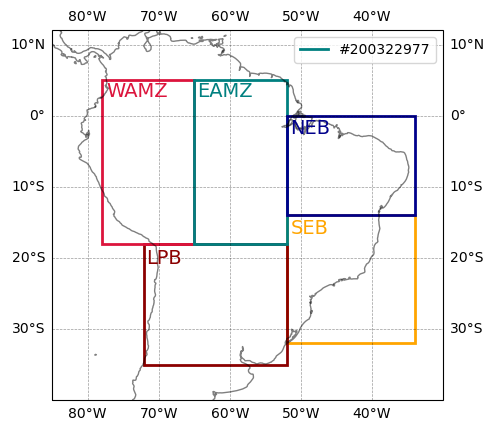

In [106]:
# Plotting

## Create regional boxes & plot them on a map ##

import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

f=14

ax = plt.axes(projection=ccrs.PlateCarree())
#hx = m.hexbin(x_210, y_210, gridsize=(8,8),cmap='Reds',alpha=0.6,vmin=0,vmax=170)
#cbar = plt.colorbar(hx, ax=ax, shrink=0.9, pad=0.1, label='Hours with MCS present')
ax.set_extent([-85,-30,-40,12], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m',alpha=0.5)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, color='k',linestyle='--')

# ax.add_patch(mpatches.Rectangle(xy=[-70, -5], width=25, height=10, linewidth=2,
#                                 facecolor='none', edgecolor='teal',
#                                 transform=ccrs.PlateCarree()))
# ax.text(0.28, 0.83, 'NAMZ',color='teal',transform=ax.transAxes)


# ax.add_patch(mpatches.Rectangle(xy=[-70, -15], width=25, height=10, linewidth=2,
#                                 facecolor='none', edgecolor='crimson',
#                                 transform=ccrs.PlateCarree()))
# ax.text(0.28, 0.63, 'SAMZ',color='crimson',transform=ax.transAxes)


### South East Brazil (55-38^w, 25-15^S) ###
### ------------------------------------ ###
seb = ax.add_patch(mpatches.Rectangle(xy=[-52, -32], width=18, height=18, linewidth=2,
                                facecolor='none', edgecolor='orange',
                                transform=ccrs.PlateCarree()))
ax.text(0.61, 0.45, 'SEB',color='orange',transform=ax.transAxes,fontsize=f)


### East Brazil (45-35^W - 25-10^S) ###
### ------------------------------- ###
# eb = ax.add_patch(mpatches.Rectangle(xy=[-45, -25], width=10, height=17, linewidth=2,
#                                 facecolor='none', edgecolor='purple',
#                                 transform=ccrs.PlateCarree()))
# ax.text(0.74, 0.57, 'EB',color='purple',transform=ax.transAxes)


### La Plata Basin (70-45^W, 35-18^S) ###
### --------------------------------- ###
lpb = ax.add_patch(mpatches.Rectangle(xy=[-72, -35], width=20, height=17, linewidth=2,
                                facecolor='none', edgecolor='darkred',
                                transform=ccrs.PlateCarree()))
ax.text(0.24, 0.37, 'LPB',color='darkred',transform=ax.transAxes,fontsize=f)


### Western Amazon (78-65^W, 18-5^S) ###
### -------------------------------- ###
wamz = ax.add_patch(mpatches.Rectangle(xy=[-78, -18], width=13, height=23, linewidth=2,
                                facecolor='none', edgecolor='crimson',
                                transform=ccrs.PlateCarree()))
ax.text(0.14, 0.82, 'WAMZ',color='crimson',transform=ax.transAxes,fontsize=f)


### Eastern Amazon (65-52^W, 18-5^S) ###
### -------------------------------- ###
eamz = ax.add_patch(mpatches.Rectangle(xy=[-65, -18], width=13, height=23, linewidth=2,
                                facecolor='none', edgecolor='teal',
                                transform=ccrs.PlateCarree()))
ax.text(0.37, 0.82, 'EAMZ',color='teal',transform=ax.transAxes,fontsize=f)


### North East Brazil (50-35^W, 15-0^S) ###
### ----------------------------------- ###
neb = ax.add_patch(mpatches.Rectangle(xy=[-52, -14], width=18, height=14, linewidth=2,
                                facecolor='none', edgecolor='darkblue',
                                transform=ccrs.PlateCarree()))
ax.text(0.61, 0.72, 'NEB',color='darkblue',transform=ax.transAxes,fontsize=f)



# singular tracks to create legend from
ax.plot(tracks.longitude[tracks.cell == 200322977],tracks.latitude[tracks.cell == 200322977], '-',linewidth=2,zorder=2, color='teal',label='#200322977')

ax.legend(loc='best')






In [107]:
cell_nos = tracks[tracks.latitude < -20]
cell_no = np.unique(cell_nos.cell.values[cell_nos.longitude < -50])

In [108]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [109]:
cell_no

array([   56,    75,   102,   124,   182,   229,   230,   256,   343,
         358,   402,   431,   449,   497,   532,   577,   585,   611,
         623,   625,   657,   763,   796,   800,   871,   883,   887,
         923,   985,  1002,  1007,  1032,  1044,  1056,  1090,  1099,
        1134,  1160,  1196,  1202,  1214,  1245,  1272,  1296,  1327,
        1332,  1399,  1409,  1415,  1423,  1464,  1470,  1516,  1594,
        1606,  1842,  1877,  1925,  1942,  2003,  2014,  2015,  2027,
        2028,  2033,  2057,  2063,  2068,  2094,  2123,  2155,  2161,
        2199,  2224,  2230,  2233,  2276,  2291,  2295,  2316,  2332,
        2339,  2349,  2377,  2386,  2387,  2465,  2472,  2473,  2475,
        2518,  2582,  2592,  2597,  2723,  2775,  2812,  2821,  2843,
        2857,  2878,  2918,  2921,  2922,  2934,  2941,  2988,  3007,
        3085,  3174,  3204,  3370,  3426,  3440,  3487,  3490,  3491,
        3495,  3517,  3525,  3532,  3543,  3575,  3636,  3648,  3670,
        3783,  3859,

In [110]:
cells = np.unique(tracks.cell.values)
cells

array([    2,     4,    13,    14,    15,    17,    21,    26,    33,
          36,    39,    42,    46,    49,    50,    51,    54,    56,
          57,    66,    75,    80,    89,    94,    98,   102,   103,
         108,   109,   115,   116,   118,   124,   137,   140,   142,
         147,   149,   162,   165,   169,   174,   180,   182,   192,
         194,   201,   202,   203,   204,   222,   223,   224,   229,
         230,   244,   245,   251,   256,   265,   267,   278,   282,
         287,   306,   309,   315,   317,   318,   329,   335,   337,
         343,   345,   356,   358,   364,   370,   374,   378,   391,
         397,   399,   402,   410,   421,   429,   431,   434,   441,
         442,   449,   470,   491,   496,   497,   506,   517,   518,
         519,   520,   532,   538,   541,   543,   552,   553,   567,
         568,   569,   571,   575,   577,   579,   585,   586,   587,
         593,   600,   603,   608,   611,   614,   620,   623,   625,
         637,   653,

In [111]:
def make_colorbar(ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl

    divider = make_axes_locatable(ax)
    orientation = kwargs.pop('orientation', 'vertical')
    if orientation == 'vertical':
        loc = 'right'
    elif orientation == 'horizontal':
        loc = 'bottom'
    
    if mappable == tbs:
        label = 'Brightness temp (K)'
        ticks = range(180, 245, 10)

    elif mappable == precips:
        label = 'Precipitation (mm hr-1)'
        ticks = range(0, 140, 20)

    elif mappable == vel:
        label = 'Vertical velocity (m s-1)'
        ticks = range(-4, 4, 1)
        
    cax = divider.append_axes(loc, '5%', pad='3%', axes_class=mpl.pyplot.Axes)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label, ticks=ticks).set_label(label=label,size=15)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label, ticks=ticks)


In [112]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [113]:
import cartopy as crs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

In [114]:
## TESTING LOOP FOR A SINGLE UNIQUE CELL (E.G. NUMBER 12) ##

## rainfall thresholds to use within filtering loop ##
precip_threshold = 1 #mm/hr
heavy_precip_threshold = 10 # mm/hr
extreme_precip_threshold = 50 # mm/hr (based on Marengo, J. A., Ambrizzi, T., Alves, L. M., Barreto, N. J., Simões Reboita, M., & Ramos, A. M. (2020). Changing trends in rainfall extremes in the metropolitan area of São Paulo: causes and impacts. Frontiers in Climate, 2, 3.)
precip_area = 40 # threshold for the minimum number of grid points that must be precipitating for a track to remain (and not be dropped from the tracks dataset). It's 40 for 10km resolution and 198 for 4.5km resolution

cold_threshold = 210

## other parameters that need to be defined before loop ##
s = generate_binary_structure(2,2) # need this in loop later on
removed = 0 # need this for loop later on


cell = 11734
subset = tracks[tracks.cell == cell]
precipitation_flag = 0
cold_core_flag = 0
rain_flag = 0
w_frame = 0 # assigning the frame number of the vertical velocity dataset to be 0 (i.e. vert_vel[w_frame,:,:,:] = vert_vel[0,:,:,:])

for feature in subset.feature.values: #find all the feature values for that unique cell / track (the feature value is a unique value for each feature in a frame /timestep)
    print("Feature:", feature)
    for frame in subset.frame[subset.feature == feature]: #find the frame / timestep that corresponds to the feature number
        print("Frame:", frame)
        print("Frame timestamp: ", str(subset['timestr'][subset.frame == frame]))

#         subset['datetime'][(subset.frame == frame) & (subset.cell == cell)] = pd.to_datetime(subset['timestr'][subset.frame == frame]) # the time at the hourly frame

        if mask.shape == precip.shape:
        
            seg = mask[frame,:,:] #printing the segmentation mask which occurs in the same frame as the feature value
            #print(seg)
            prec = precip[frame,:,:] #printing the precip timesteps which occurs in the same frame as the feature value
            #print(prec)
            brightness_temp = tb[frame,:,:] # printing the tb timesteps which occurs in the same frame as the feature value
            brightness_temp = tb[frame,:,:] # printing the tb timesteps which occurs in the same frame as the feature value


            featureid = subset.feature[subset.frame == frame].values[0] #find the feature number at each timestep / frame of the cells lifetime (it changes over time and doesn't stay constant)
            #print('featureid: {}'.format(featureid)) #we now know all the feature numbers that belong to a single cell over its lifetime
            
            #print("Shape of seg:", np.shape(seg))
            labels, num_labels = ndimage.label(seg, structure = generate_binary_structure(2,2)) #this line uses ndimage package for image processing. It generates arrays of numbers and decides what are joined together and what aren't.
            # In other words, it does image segmentation tasks, such as finding connected components and labeling objects in an image.
            # (i.e. it generates the locations of all contiguous fields of the segmentation mask that belong to a specific cell at a specific timestep and gives it a label. The number of labels is also recorded (the number of segmented areas in the timestep))

            if featureid not in seg: #check that the feature id number at each timestep is within the segmentation mask, if not, it is ignored and we continue
                continue
            else:

                label = np.unique(labels[seg == featureid])[0] #put a label where the labels match for both the feature id and the segmentation mask
                seg_mask = seg.where(labels == label)

                #create coordinates from mask
                seg_mask.coords['mask'] = (('latitude', 'longitude'), seg_mask.data)

                #apply mask to precip dataset
                precip_values = prec.where(seg_mask.coords['mask'].values > 0) # creating a new dataset called 'precip_values' with only the precip values where the seg_mask pixel is labelled as greater than 0 (i.e. the MCS region)
                #print('precip values: {}'.format(precip_values)
                array = precip_values.values.flatten() * 3600 # precip values are converted to 1D numpy array and multiplied by 3600 to convert from kg m-2 s-1 to mm / hr
                values = array[~np.isnan(array)] #removes NaNs from the precip array for further calculations
                #print(values)

                total_precip = np.nansum(values[values > 0]) #working out the total precip associated with the mask. First, values of 0 are removed to only consider precipitating pixels. Then np.nansum is used to compute the sum of all precipitating values within the mask.
                #print('total precip: {}'.format(total_precip))
                subset['total_precip'][(subset.feature == featureid) & (subset.frame == frame)  & (subset.cell == cell)] = total_precip

                rain_features = values[values >= precip_threshold].shape[0] #number of pixels within the mask that meet the 1 mm/hr precip threshold
                #print('rain features: {}'.format(rain_features))
                #print('precip area:', precip_area)
                #subset['rain_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = rain_features

                subset['light_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= precip_threshold]) #total rain from all pixel where the rainfall threshold of 1 mm/hr is met

                subset['heavy_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= heavy_precip_threshold]) #total rain from all pixel where the heavy rainfall threshold of 10 mm/hr is met
                rain_features_heavy = values[values >= heavy_precip_threshold].shape[0] #number of pixels within the mask that meet the heavy rainfall threshold of 10 mm/hr

                subset['extreme_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = np.nansum(values[values >= extreme_precip_threshold]) #total rain from all pixel where the extreme rainfall threshold of 50 mm/hr is met
                rain_features_extreme = values[values >= extreme_precip_threshold].shape[0] #number of pixels within the mask that meet the extreme rainfall threshold of 50 mm/hr

                subset['max_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values.max()

                subset['mean_precip_total'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values.mean()

                subset['mean_precip'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values[values > precip_threshold].mean()

                subset['max_precip_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = precip_values.where(precip_values==precip_values.max(), drop=True).squeeze().latitude

                subset['max_precip_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = precip_values.where(precip_values==precip_values.max(), drop=True).squeeze().longitude

                # cold core filter using the same image processing mask ##
                values_tb_1 = brightness_temp.where(seg_mask.coords['mask'].values > 0)
                array_tb = values_tb_1.values.flatten() # precip values are converted to 1D numpy array and multiplied by 3600 to convert from kg m-2 s-1 to mm / hr
                values_tb = array_tb[~np.isnan(array_tb)] #removes NaNs from the precip array for further calculations
                #print(values_tb)
                #print(values_tb[values_tb <= 190].shape[0])
                #array = values_tb.to_dataframe
                #values_tb = array().toa_outgoing_longwave_flux #Tb values in 1D array format to use in section below:

                subset['tb_mean'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb.mean()

                subset['tb_min'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb.min()

                subset['tb_210'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 210]).shape[0]
                
                subset['tb_200'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 200]).shape[0]             

                subset['tb_190'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = (values_tb[values_tb <= 190]).shape[0]

                subset['min_tb_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb_1.where(values_tb_1==values_tb_1.min(), drop=True).squeeze().latitude

                subset['min_tb_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_tb_1.where(values_tb_1==values_tb_1.min(), drop=True).squeeze().longitude  
       

                # Assigning cold core flag
                if values_tb.min() <= cold_threshold:
                    cold_core_flag += 1
                    subset['cold_core_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = cold_core_flag

                if rain_features >= precip_area: # if the number of precipitating pixels exceeds the miniumum pixel number... 
                    rain_flag += 1
                    subset['rain_flag'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = rain_flag
                    precipitation_flag += rain_features # add rain pixels to the precipitation flag

                # Colocated pixels of Tb and precip
                prec = prec * 3600 # converting from kg m-2 s-1 to mm/hr

                colocated = prec.where((prec >= 1) & (brightness_temp <= 210) & (seg_mask.coords['mask'].values > 0)) #finding only the locations where all tb and precip criteria are met

                print("Number of colocated pixels:", colocated.values[~np.isnan(colocated)].shape[0])
                subset['colocated_pixels'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = colocated.values[~np.isnan(colocated)].shape[0]


#                 #plots for each timestep:
#                 #========================
#                 xlabels=[-80,-70,-60,-50,-40,-30]
#                 ylabels= [-30,-20,-10]

#                 # markersize 
#                 s = 100
#                 #fontsize
#                 f=20

#                 #loop for each timestep:
#                 fig = plt.figure(figsize=(14,10))
#                 plt.subplots_adjust(wspace=0.4,hspace=0)

#                 ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
#                 tbs = brightness_temp.where(seg_mask.coords['mask'].values > 0).plot(ax=ax1,zorder=1,cmap='magma_r', vmin=180, vmax=240, add_colorbar=False)
#                 make_colorbar(ax1, tbs, orientation='vertical')
#                 ax1.scatter(subset.min_tb_lon[subset.frame == frame].values[0],subset.min_tb_lat[subset.frame == frame].values[0],color='lightblue',marker='o', s = s, transform=ccrs.PlateCarree(),label='Tb minima')
#                 ax1.coastlines(linewidth=2)
#                 ax1.set_title('Tb', loc='center', fontsize=f)
#                 ax1.set_xticks(xlabels, xlabels)
#                 ax1.set_yticks(ylabels,ylabels)
#                 ax1.set_xlim(-75,-55)
#                 ax1.set_ylim(-10,10)
#                 ax1.set_xticklabels(ax1.get_xticks().astype(int),fontsize=14)
#                 ax1.set_yticklabels(ax1.get_yticks().astype(int),fontsize=14)
#                 ax1.set_xlabel('Lon $^\circ$E',  fontsize=14)
#                 ax1.set_ylabel('Lat $^\circ$N',  fontsize=14)
#                 axins = inset_axes(ax1, width=1.2, height=1, loc="upper left", 
#                 axes_class=crs.mpl.geoaxes.GeoAxes, 
#                 axes_kwargs=dict(map_projection=crs.crs.PlateCarree(),extent=[-85,-30,-40,12]))
#                 axins.add_feature(crs.feature.COASTLINE)
#                 axins.add_patch(mpatches.Rectangle(xy=[-75, -10], width=20, height=20, linewidth=2,facecolor='none', edgecolor='teal',transform=ccrs.PlateCarree()))
#                 ax1.legend(loc='upper right',fontsize=14)

#                 ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
#                 precips = prec.where(seg_mask.coords['mask'].values > 0).plot(ax=ax2,zorder=1,cmap='viridis_r', vmin=0, vmax=60, add_colorbar=False)
#                 make_colorbar(ax2, precips, orientation='vertical')
#                 ax2.scatter(subset.max_precip_lon[subset.frame == frame].values[0],subset.max_precip_lat[subset.frame == frame].values[0],color='crimson',marker='o', s = s, transform=ccrs.PlateCarree(), label='precipitation maxima')
#                 ax2.set_title('Precip', loc='center', fontsize=f)
#                 ax2.coastlines(linewidth=2)
#                 ax2.set_xticks(xlabels, xlabels)
#                 ax2.set_yticks(ylabels,ylabels)
#                 ax2.set_xlim(-75,-55)
#                 ax2.set_ylim(-10,10)
#                 ax2.set_xticklabels(ax2.get_xticks().astype(int),fontsize=14)
#                 ax2.set_yticklabels(ax2.get_yticks().astype(int),fontsize=14)
#                 ax2.set_xlabel('Lon $^\circ$E',  fontsize=14)
#                 ax2.set_ylabel('Lat $^\circ$N',  fontsize=14)
#                 ax2.legend(loc='upper right',fontsize=14)

#                 plt.suptitle(subset.timestr[subset.frame == frame].to_string(index=False), y=0.85,x=0.5,fontsize = 25)
#                 plt.tight_layout()

#                 #plt.savefig('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_RG_no_precip' +str(frame) + '.jpg')
#                 plt.clf()


            # ADDING IN IF STATEMENT FOR VERTICAL VELOCITY EVERY 3 TIMESTEPS#

            vert_vel_df = pd.DataFrame()

            vert_vel_df['time'] = vert_vel[:,:,:].t

            for i in np.arange(0, vert_vel_df.shape[0]):
                #print(i)
                time_vert_vel = cftime.datetime.strftime(vert_vel_df.time[i], '%Y-%m-%d %H:30:00') # adding in the 30 so that its the hour of the vert_vel dataset + 30 mins to match up with the 1 hourly data
                #print(time_vert_vel)
                if subset['time'][subset.frame == frame].to_string(index=False)==time_vert_vel:
                    print('True:', time_vert_vel)

            # for time in vert_vel_df['time'].dt.strftime('%Y-%m-%d %H:30:00'): # adding in the 30 so that its the hour of the vert_vel dataset + 30 mins to match up with the 1 hourly data
            # #   print('skipping vert vel')
            #     if subset['time'][subset.frame == frame].to_string(index=False)==time:
            #         print(time)
                    
                    for i in vert_vel_df.index:
                        if cftime.datetime.strftime(vert_vel_df.time[i], '%Y-%m-%d %H:30:00') == time_vert_vel: #if the timestamp in the vert_vel dataset matches with the original frame timestamp...
                            w_frame = i

                    # for i in vert_vel_df.index:
                    #     if (vert_vel[i,:,:].datetime.dt.strftime('%Y-%m-%d %H:30:00')) == time: #if the timestamp in the vert_vel dataset matches with the original frame timestamp...
                    #         w_frame = i

                            vel_w = vert_vel[w_frame,:,:] #find the vertical velocity values for the frame in the vert_vel dataset that corresponds to the frame in the hourly datasets (i.e if the original frame is at 03:00, then find the w values in the vert_vel dataset that are also at 03:00. THEY WILL BE DIFFERENT FRAME NUMBERS BECAUSE THE ORIGINAL IS 1-HOURLY AND W IS 3-HOURLY!!!)

                            print("original frame timestamp: ", str(subset['timestr'][subset.frame == frame]))
                            print("w frame number: ", w_frame)
                            print("w frame timestamp: ", str(vert_vel[w_frame,:,:].t))

                            seg_mask.coords['mask'] = (('longitude', 'latitude'), seg_mask.data) 
                            values_vel_1 = vel_w.where(seg_mask.coords['mask'].values > 0) # extract only the w values within the segmented cell
                            array_vel = values_vel_1.values.flatten()
                            values_vel = array_vel[~np.isnan(array_vel)] # convert these into a 1D array with no nans
                            print("maximum w within mask:", values_vel.max())

#                 #             ax = plt.axes(projection=ccrs.PlateCarree())

                            subset['w_max'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel.max() #maximum vertical velocity over the segmented area
                            subset['w_mean'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel.mean() # mean vertical velocity over the segmented area

                            w_up = values_vel[values_vel >= 0.000000001] # isolating just positive values of w (just upward motion and not downward)

                            subset['w_mean_up'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = w_up.mean() # mean upward vertical velocity over the segmented area

                            subset['max_w_up_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.max(), drop=True).squeeze().latitude

                            subset['max_w_up_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.max(), drop=True).squeeze().longitude

                            subset['max_w_down_lat'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.min(), drop=True).squeeze().latitude

                            subset['max_w_down_lon'][(subset.feature == featureid) & (subset.frame == frame) & (subset.cell == cell)] = values_vel_1.where(values_vel_1==values_vel_1.min(), drop=True).squeeze().longitude

#                 #             ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
#                 #             vel = vel_w.where(seg_mask.coords['mask'].values > 0).plot(ax=ax3,zorder=1,cmap='RdBu_r',vmin=-4, vmax=4, add_colorbar=False )
#                 #             make_colorbar(ax3, vel, orientation='vertical')
#                 #             ax3.scatter(subset.max_w_up_lon[subset.frame == frame].values[0],subset.max_w_up_lat[subset.frame == frame].values[0],color='k',marker='o', s = s, transform=ccrs.PlateCarree(), label='updraft velocity maxima')                                                        
#                 #             ax3.set_title('Vertical velocity', loc='center', fontsize=f)
#                 #             ax3.coastlines(linewidth=2)
#                 #             ax3.set_xticks(xlabels, xlabels)
#                 #             ax3.set_yticks(ylabels,ylabels)
#                 #             ax3.set_xlim(-75,-55)
#                 #             ax3.set_ylim(-30,-15)
#                 #             ax3.set_xticklabels(ax3.get_xticks().astype(int),fontsize=14)
#                 #             ax3.set_yticklabels(ax3.get_yticks().astype(int),fontsize=14)
#                 #             ax3.set_xlabel('Lon $^\circ$E',  fontsize=14)
#                 #             ax3.set_ylabel('Lat $^\circ$N',  fontsize=14)
#                 #             ax3.legend(loc='upper right',fontsize=14)

#                 #             #plt.suptitle(subset.timestr[subset.frame == frame].to_string(index=False), y=0.7,x=0.5,fontsize = 25)
#                 #             #plt.tight_layout()

#                 #             #plt.savefig('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_NOTGRIDDED' +str(frame) + '.jpg')
#                 #             #plt.clf()


                #ADD ANOTHER TIMESTEP ONTO W_FRAME FOR 3HRLY VERTICAL VELOCITY 
                w_frame = w_frame + 1  #add 1 to the vertical_velocity frame ready for the next time the hours are the same

            else:
                print("Skipping this frame and assinging NaN") # if the hour doesn't correspond with one of the 3-hourly values, then assign NaNs to the dataframe
#             #        #plt.savefig('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_REGRIDDED' +str(frame) + '.jpg')
#             #        #plt.clf()


if cold_core_flag == 0:
    subset = subset.drop(subset[subset.cell == cell].index)
    removed += 1 #print the number of tracks that have been removed from the original dataset

    #save subset to deleted tracks folder
    #subset.to_hdf('Save/deleted_tracks/cold_core/tracks_2005_01_cell_{}'.format(cell), 'table')
    
if rain_flag == 0: #if the minumum precipitating pixel thresholds aren't met...
    #remove corresponding cell from the tracks dataframe
    #subset = subset.drop(subset[subset.cell == cell].index)
    removed += 1 #print the number of tracks that have been removed from the original dataset

    #save subset to deleted tracks folder
    #subset.to_hdf('Save/deleted_tracks/precip/tracks_2005_01_cell_{}'.format(cell), 'table')

else:
    print("Completed cell ", cell)    
    # save precip track files
    #subset.to_hdf('Save/CC&PF/tracks_2005_01_cell_{}.h5'.format(cell), 'table')

Feature: 50758
Frame: 4124
Frame timestamp:  50757    2002-06-22 20:30:00
Name: timestr, dtype: object
Number of colocated pixels: 49
Skipping this frame and assinging NaN
Feature: 50771
Frame: 4125
Frame timestamp:  50770    2002-06-22 21:30:00
Name: timestr, dtype: object
Number of colocated pixels: 48
True: 2002-06-22 21:30:00
original frame timestamp:  50770    2002-06-22 21:30:00
Name: timestr, dtype: object
w frame number:  1375
w frame timestamp:  <xarray.DataArray 't' ()>
array(cftime.Datetime360Day(2002, 6, 22, 21, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    t        object 2002-06-22 21:00:00
Attributes:
    standard_name:  time
    long_name:      t
    axis:           T
maximum w within mask: 6.6824064
Skipping this frame and assinging NaN
Feature: 50786
Frame: 4126
Frame timestamp:  50785    2002-06-22 22:30:00
Name: timestr, dtype: object
Number of colocated pixels: 51
Skipping this frame and assinging NaN
Feature: 50801
Frame: 4127
Frame timestamp:

<xarray.DataArray 'dz_dt' ()>
array(2.9267163, dtype=float32)
Coordinates:
    t        object 2002-06-23 00:00:00

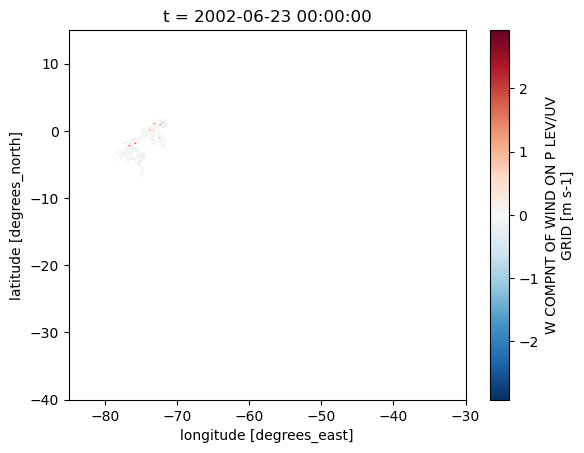

In [115]:
seg_mask.coords

seg_mask.coords['mask'] = (('latitude', 'longitude'), seg_mask.data)

vel_w.where(seg_mask.coords['mask'].values > 0).plot(zorder=1)

vel_w.where(seg_mask.coords['mask'].values > 0).max()


In [116]:
## Location of the precipitation maxima within the cloud shield at each timestep ##

da = prec.where(seg_mask.coords['mask'].values > 0)

da.where(da==da.max(), drop=True).squeeze().latitude

<xarray.DataArray 'latitude' ()>
array(-0.55000001)
Coordinates:
    time       object 2002-06-23 07:30:00
    latitude   float64 -0.55
    longitude  float64 -74.25
Attributes:
    axis:           Y
    bounds:         latitude_bnds
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude

158

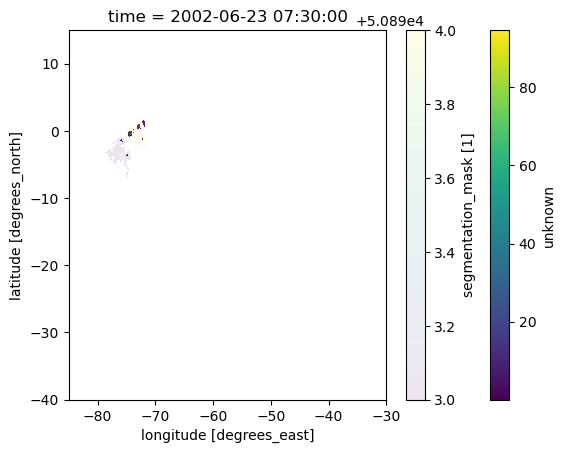

In [117]:
## code for the number of colocated pixels within each timestep of a cloud shield ##

#prec = prec * 3600 # converting from kg m-2 s-1 to mm/hr

colocated = prec.where((brightness_temp <= 210) & (seg_mask.coords['mask'].values > 0)) #finding only the locations where all tb and precip criteria are met
colocated.plot()
seg_mask.plot(alpha=0.1)

colocated_pixels = colocated.values[~np.isnan(colocated)].shape[0]
colocated_pixels

*** Animation for single cell (1209) over time showing all 3 variables (Tb, precip and w) within the masked area as well as maxima / minima locations ***

Text(0, 0.5, 'Lat $^\\circ$N')

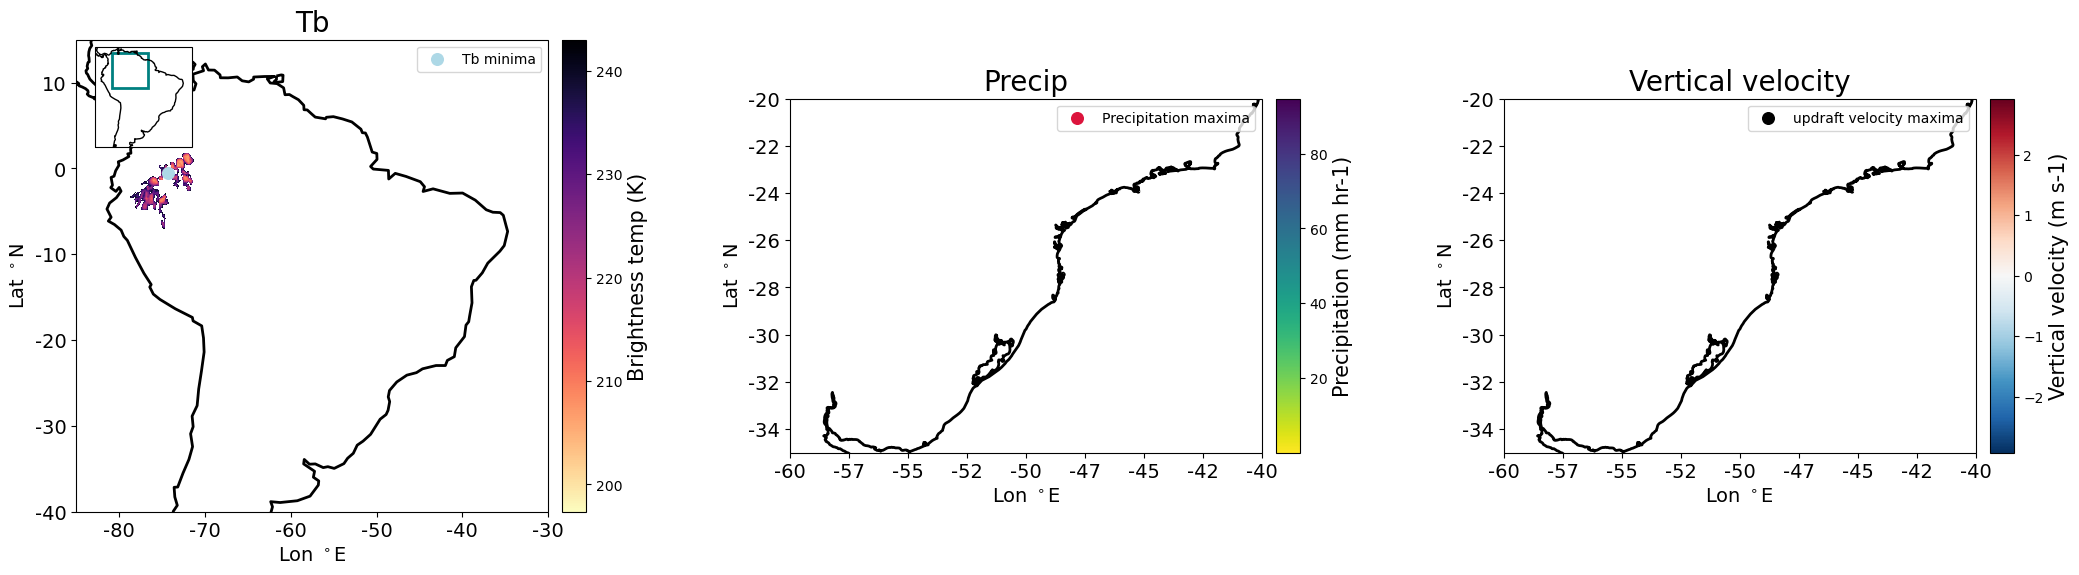

In [120]:
#plots for each timestep:
#========================
def make_colorbar(ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib as mpl

    divider = make_axes_locatable(ax)
    orientation = kwargs.pop('orientation', 'vertical')
    if orientation == 'vertical':
        loc = 'right'
    elif orientation == 'horizontal':
        loc = 'bottom'
    
    if mappable == tb:
        label = 'Brightness temp (K)'
    elif mappable == precips:
        label = 'Precipitation (mm hr-1)'
    elif mappable == vel:
        label = 'Vertical velocity (m s-1)'
        
    cax = divider.append_axes(loc, '5%', pad='3%', axes_class=mpl.pyplot.Axes)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label).set_label(label=label,size=15)
    ax.get_figure().colorbar(mappable, cax=cax, orientation=orientation, label=label)

#creating list of dates and times for the plot titles:
# time = tb.coord('time')
# dates = time.units.num2date(time.points)
import cartopy as crs
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
#axis_extent=[-80,-30,-35,12]
xlabels=[-50,-40,-30]
ylabels= [-30,-20,-10]

# markersize 
s = 70
#fontsize
f=20

#loop for each timestep:
fig = plt.figure(figsize=(25,15))
plt.subplots_adjust(wspace=0.4,hspace=0)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
#cbar1 = plt.colorbar(tb, ax=ax1, label= 'brightness temperature (K)', orientation='vertical', shrink=0.5)
tb = brightness_temp.where(seg_mask.coords['mask'].values > 0).plot(ax=ax1,zorder=1,cmap='magma_r', add_colorbar=False)
make_colorbar(ax1, tb, orientation='vertical')
ax1.coastlines(linewidth=2)
#gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.4, color='k',linestyle='--')
ax1.scatter(subset.min_tb_lon[subset.frame == frame].values[0],subset.min_tb_lat[subset.frame == frame].values[0],color='lightblue',marker='o', s = s, transform=ccrs.PlateCarree(),label='Tb minima')
ax1.set_title('Tb', loc='center', fontsize=f)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
#ax1.set_xlim(-60,-40)
#ax1.set_ylim(-35, -20)
ax1.legend(loc='upper right')
ax1.set_xticklabels(ax1.get_xticks().astype(int),fontsize=14)
ax1.set_yticklabels(ax1.get_yticks().astype(int),fontsize=14)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=14)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=14)
axins = inset_axes(ax1, width=1.2, height=1, loc="upper left", 
                   axes_class=crs.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=crs.crs.PlateCarree(),extent=[-85,-30,-40,12]))
axins.add_feature(crs.feature.COASTLINE)
axins.add_patch(mpatches.Rectangle(xy=[-75, -10], width=20, height=20, linewidth=2,
                                facecolor='none', edgecolor='teal',
                                transform=ccrs.PlateCarree()))



ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
precips = prec.where(seg_mask.coords['mask'].values > 0).plot(ax=ax2,zorder=1,cmap='viridis_r',add_colorbar=False)
make_colorbar(ax2, precips, orientation='vertical')
ax2.scatter(subset.max_precip_lon[subset.frame == frame].values[0],subset.max_precip_lat[subset.frame == frame].values[0],color='crimson',marker='o', s = s, transform=ccrs.PlateCarree(),label='Precipitation maxima')
ax2.set_title('Precip', loc='center', fontsize=f)
ax2.coastlines(linewidth=2)
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_xlim(-60,-40)
ax2.set_ylim(-35,-20)
ax2.legend(loc='upper right')
ax2.set_xticklabels(ax2.get_xticks().astype(int),fontsize=14)
ax2.set_yticklabels(ax2.get_yticks().astype(int),fontsize=14)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=14)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=14)

ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
vel = vel_w.where(seg_mask.coords['mask'].values > 0).plot(ax=ax3,zorder=1, add_colorbar=False)
make_colorbar(ax3, vel, orientation='vertical')
ax3.scatter(subset.max_w_up_lon[subset.frame == frame].values[0],subset.max_w_up_lat[subset.frame == frame].values[0],color='k',marker='o', s = s, transform=ccrs.PlateCarree(), label='updraft velocity maxima')                                           
ax3.set_title('Vertical velocity', loc='center', fontsize=f)
ax3.coastlines(linewidth=2)
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_xlim(-60,-40)
ax3.set_ylim(-35,-20)
ax3.legend(loc='upper right')
ax3.set_xticklabels(ax3.get_xticks().astype(int),fontsize=14)
ax3.set_yticklabels(ax3.get_yticks().astype(int),fontsize=14)
ax3.set_xlabel('Lon $^\circ$E',  fontsize=14)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=14)



In [119]:
subset

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,cell,time_cell,total_precip,rain_flag,light_precip,heavy_precip,extreme_precip,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,cold_core_flag,tb_210,tb_200,tb_190,w_max,w_mean,w_mean_up,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
50757,4124,119,937.681527,302.851419,4118,240,50758,2002-06-22 20:30:00,2002-06-22 20:30:00,-2.063949,-72.774454,11734,0 days 00:00:00,1727.822266,1,1684.416748,1160.709717,54.307549,54.307549,2.537184,8.176781,196.538437,220.759567,1,100,5,0,NaN,NaN,NaN,-1.55,-72.650002,-1.85,-72.849998,0,0,0,0,49
50770,4125,123,943.020873,288.589210,4080,240,50771,2002-06-22 21:30:00,2002-06-22 21:30:00,-1.847704,-73.352085,11734,0 days 01:00:00,1470.819336,2,1413.082397,944.741211,0.000000,48.919399,2.191981,7.679796,195.339172,221.137650,2,115,6,0,6.682406,0.056174,0.295497,-1.15,-73.050003,-1.15,-72.650002,-1.15,-72.650002,-0.55,-73.25,48
50785,4126,123,942.764448,279.957796,4638,240,50786,2002-06-22 22:30:00,2002-06-22 22:30:00,-1.858089,-73.701660,11734,0 days 02:00:00,2027.973145,3,1972.679688,1437.610229,53.844963,53.844963,2.654415,9.305093,196.619263,220.961472,3,118,27,0,NaN,NaN,NaN,0.15,-73.449997,-1.05,-73.050003,0,0,0,0,51
50800,4127,121,936.134525,269.953455,4101,240,50801,2002-06-22 23:30:00,2002-06-22 23:30:00,-2.126601,-74.106835,11734,0 days 03:00:00,1537.285889,4,1499.989624,995.325684,231.315826,65.384415,2.301326,8.720870,195.691513,219.510193,4,143,10,0,NaN,NaN,NaN,-1.75,-74.050003,-1.65,-74.050003,0,0,0,0,46
50813,4128,71,918.815444,255.970396,6782,240,50814,2002-06-23 00:30:00,2002-06-23 00:30:00,-2.828024,-74.673135,11734,0 days 04:00:00,1665.912598,5,1605.918457,933.885986,51.828228,51.828228,1.492753,6.747557,199.733322,221.226120,5,163,2,0,2.399024,0.037869,0.179897,-2.25,-75.349998,-1.65,-74.25,-3.35,-73.150002,-2.55,-73.150002,56
50826,4129,71,924.954175,270.102459,10179,240,50827,2002-06-23 01:30:00,2002-06-23 01:30:00,-2.579405,-74.100801,11734,0 days 05:00:00,1970.501831,6,1878.548584,1068.357300,222.465485,61.494080,1.182774,6.685226,200.248627,221.585419,6,191,0,0,NaN,NaN,NaN,-4.65,-72.550003,-4.15,-71.349998,0,0,0,0,55
50839,4130,70,945.646352,283.054179,15603,240,50840,2002-06-23 02:30:00,2002-06-23 02:30:00,-1.741374,-73.576265,11734,0 days 06:00:00,3320.457031,7,3154.897461,1716.214355,102.104141,51.870533,1.298575,6.531879,198.453018,223.609314,7,218,8,0,NaN,NaN,NaN,0.25,-72.050003,-4.65,-72.650002,0,0,0,0,129
50853,4131,60,955.369672,267.326131,12870,240,50854,2002-06-23 03:30:00,2002-06-23 03:30:00,-1.347578,-74.213233,11734,0 days 07:00:00,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0
50866,4132,57,946.796823,260.063255,13368,240,50867,2002-06-23 04:30:00,2002-06-23 04:30:00,-1.694779,-74.507387,11734,0 days 08:00:00,3572.932129,8,3416.452148,2348.018799,285.540527,65.591774,1.637457,8.173330,202.377457,226.722961,8,91,0,0,NaN,NaN,NaN,-1.45,-75.25,-0.45,-72.949997,0,0,0,0,50
50874,4133,60,948.112046,255.867280,11022,240,50875,2002-06-23 05:30:00,2002-06-23 05:30:00,-1.641512,-74.677311,11734,0 days 09:00:00,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0


In [328]:
##ANIMATION CODE##
import PIL
import numpy as np
from PIL import Image

image_frames=[]

frames = np.arange(15,22)
#print(frames)

for k in frames:
        print('single_MCS_animation_frame_RG_no_precip' +str(k) + '.jpg')
        new_frame = PIL.Image.open('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_RG_no_precip' +str(k) + '.jpg')
        image_frames.append(new_frame)

image_frames[0].save('/project/cssp_brazil/mcs_tracking_HG/single_MCS_animation_frame_RG_no_precip.gif', format = 'GIF', append_images = image_frames[1: ], save_all = True, duration = 1200, loop = 3)

single_MCS_animation_frame_RG_no_precip15.jpg
single_MCS_animation_frame_RG_no_precip16.jpg
single_MCS_animation_frame_RG_no_precip17.jpg
single_MCS_animation_frame_RG_no_precip18.jpg
single_MCS_animation_frame_RG_no_precip19.jpg
single_MCS_animation_frame_RG_no_precip20.jpg
single_MCS_animation_frame_RG_no_precip21.jpg


**Looking closer at differences in single MCSs when kept in original but removed for no precip in regridded**

In [135]:
no_precip_regridded = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/final_tracks_CPM_REGRIDDED/merged/1998/no_precip_1998.hdf', 'table')
CCPF_original = pd.read_hdf('/project/cssp_brazil/mcs_tracking_HG/final_tracks_CPM/merged/1998/CCPF_1998.hdf', 'table')

In [136]:
no_precip_regridded

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,convective_precip,heavy_precip,extreme_precip,heavy_rain_flag,extreme_rain_flag,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,...,tb_190,tb_180,w_max,w_min,w_mean,w_mean_up,w_mean_down,w_up_area,w_down_area,w_0.1_up,w_1_up,w_5_up,w_0.1_down,w_1_down,w_5_down,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
62313,5603,70,1123.430032,952.354815,2129,240,62314,1998-08-22 11:30:00,1998-08-22 11:30:00,5.458865,313.530421,14019,0 days 00:00:00,1103.164673,128,1072.040894,739.660645,0.000000,38,0,37.556976,3.151899,8.375319,197.224884,214.679932,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-08-22 11:30:00,5.85,-46.450001,5.35,-46.450001,0,0,0,0,79
62325,5604,69,1123.679166,948.871803,2491,240,62326,1998-08-22 12:30:00,1998-08-22 12:30:00,5.468955,313.389370,14019,0 days 01:00:00,1230.723145,139,1202.947510,807.255127,0.000000,40,0,41.975327,2.987192,8.654299,199.656784,218.233688,...,0,0,4.112953,-0.538776,0.089763,0.224097,-0.097680,240.0,172.0,86.0,16.0,0.0,59.0,0.0,0.0,1998-08-22 12:30:00,5.85,-45.75,5.85,-45.75,5.85,-45.650002,5.95,-46.650002,47
62334,5605,81,1123.755548,948.147809,2905,240,62335,1998-08-22 13:30:00,1998-08-22 13:30:00,5.472048,313.360051,14019,0 days 02:00:00,1377.794434,132,1347.232666,1040.131348,58.691177,46,1,58.691177,2.870405,10.206308,199.690506,220.236496,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-08-22 13:30:00,5.35,-45.650002,5.85,-45.950001,0,0,0,0,44
62343,5606,85,1122.503694,943.887686,3080,240,62344,1998-08-22 14:30:00,1998-08-22 14:30:00,5.421349,313.187499,14019,0 days 03:00:00,1534.815186,152,1499.666870,1074.368164,112.203644,46,2,62.026680,3.021290,9.866229,200.548965,221.463303,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-08-22 14:30:00,5.45,-46.650002,5.75,-47.25,0,0,0,0,46
62349,5607,85,1121.832784,940.126825,3018,240,62350,1998-08-22 15:30:00,1998-08-22 15:30:00,5.394179,313.035196,14019,0 days 04:00:00,1580.090454,140,1539.022217,1180.455444,447.721497,43,6,94.524895,3.231269,10.993016,194.390732,219.891418,...,0,0,5.720594,-0.520466,0.112994,0.321892,-0.069491,228.0,261.0,89.0,24.0,1.0,54.0,0.0,0.0,1998-08-22 15:30:00,5.55,-46.450001,5.55,-46.450001,5.55,-46.349998,5.65,-45.650002,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67312,6115,226,1174.118637,791.270550,7727,240,67313,1998-09-12 19:30:00,1998-09-12 19:30:00,7.511755,307.006501,15121,0 days 09:00:00,833.463623,75,803.569702,646.343018,119.040817,24,2,60.516697,0.657306,10.714263,193.580521,216.480331,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 19:30:00,7.25,-53.75,7.15,-54.150002,0,0,0,0,53
67323,6116,232,1177.736231,792.432884,7105,240,67324,1998-09-12 20:30:00,1998-09-12 20:30:00,7.658266,307.053572,15121,0 days 10:00:00,826.610046,75,802.971436,627.786987,53.077145,27,1,53.077145,0.705901,10.706285,195.064926,218.966599,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 20:30:00,7.75,-53.049999,7.35,-53.950001,0,0,0,0,36
67330,6117,234,1180.699601,792.982786,6309,240,67331,1998-09-12 21:30:00,1998-09-12 21:30:00,7.778285,307.075841,15121,0 days 11:00:00,901.517334,59,885.909607,769.914612,188.926361,24,3,71.468948,0.878672,15.015417,197.434570,221.584946,...,0,0,4.092428,-0.769858,0.008065,0.131784,-0.076306,416.0,610.0,50.0,13.0,0.0,140.0,0.0,0.0,1998-09-12 21:30:00,8.55,-50.849998,7.45,-53.950001,8.55,-50.349998,8.65,-50.049999,17
67338,6118,219,1188.882235,800.940420,6002,240,67339,1998-09-12 22:30:00,1998-09-12 22:30:00,8.109679,307.398130,15121,0 days 12:00:00,1033.109497,56,1018.521301,909.330811,319.995483,29

In [137]:
CCPF_original

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,cell,time_cell,total_precip,rain_flag,convective_precip,heavy_precip,extreme_precip,heavy_rain_flag,extreme_rain_flag,max_precip,mean_precip_total,mean_precip,tb_min,tb_mean,...,tb_190,tb_180,w_max,w_min,w_mean,w_mean_up,w_mean_down,w_up_area,w_down_area,w_0.1_up,w_1_up,w_5_up,w_0.1_down,w_1_down,w_5_down,datetime,max_precip_lat,max_precip_lon,min_tb_lat,min_tb_lon,max_w_up_lat,max_w_up_lon,max_w_down_lat,max_w_down_lon,colocated_pixels
15651,1380,93,771.369817,211.990152,2412,240,15652,1998-02-27 12:30:00,1998-02-27 12:30:00,-8.799573,283.545652,3829,0 days 00:00:00,5355.662598,627,5183.308594,3400.977539,210.200928,145,4,54.172398,2.221345,8.266840,191.876343,213.798599,...,0,0,6.245428,-0.770148,0.116120,0.369728,-0.127384,1181.0,1230.0,536.0,112.0,6.0,484.0,0.0,0.0,1998-02-27 12:30:00,-8.004551,283.627045,-8.04505,283.546051,-8.510799,284.133301,-8.875299,283.3638,441
15660,1381,90,775.818514,218.611922,4572,240,15661,1998-02-27 13:30:00,1998-02-27 13:30:00,-8.619401,283.813843,3829,0 days 01:00:00,9654.384766,1120,9375.063477,6258.664062,1096.904419,254,16,95.511696,2.109326,8.370592,190.771011,214.785538,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-02-27 13:30:00,-8.20705,284.234558,-8.126051,284.234558,0,0,0,0,636
15670,1382,96,773.524616,217.623450,5171,240,15671,1998-02-27 14:30:00,1998-02-27 14:30:00,-8.712304,283.773813,3829,0 days 02:00:00,10956.796875,1035,10602.655273,7469.211914,3058.989746,243,42,130.999695,2.118074,10.244111,188.209641,215.083878,...,23,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-02-27 14:30:00,-7.92355,284.234558,-8.08555,284.194061,0,0,0,0,547
15679,1383,91,767.841475,228.466812,7251,240,15680,1998-02-27 15:30:00,1998-02-27 15:30:00,-8.942471,284.212966,3829,0 days 03:00:00,13494.519531,1359,13084.945312,9422.879883,3267.527588,330,47,118.886246,1.860030,9.628363,190.300110,215.242966,...,0,0,7.813848,-1.756472,0.058822,0.300728,-0.131652,3196.0,4059.0,1003.0,233.0,31.0,1591.0,17.0,0.0,1998-02-27 15:30:00,-9.50305,285.24704,-8.369051,284.113037,-8.510799,286.60379,-8.227299,284.173798,824
15691,1384,160,765.556522,225.455483,8047,240,15692,1998-02-27 16:30:00,1998-02-27 16:30:00,-9.035011,284.090986,3829,0 days 04:00:00,15722.656250,1541,15337.197266,10721.303711,4310.264648,356,56,143.169525,1.955311,9.952756,188.921143,214.815125,...,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-02-27 16:30:00,-10.758551,285.530548,-10.799051,285.530548,0,0,0,0,919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67312,6115,226,1174.118637,791.270550,7727,240,67313,1998-09-12 19:30:00,1998-09-12 19:30:00,7.511755,307.006501,15121,0 days 09:00:00,5090.797363,371,4988.981934,4122.369629,2028.004639,112,26,146.270691,0.658406,13.447391,193.396286,216.192764,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 19:30:00,7.304451,306.266541,7.101948,305.861542,0,0,0,0,276
67323,6116,232,1177.736231,792.432884,7105,240,67324,1998-09-12 20:30:00,1998-09-12 20:30:00,7.658266,307.053572,15121,0 days 10:00:00,5245.123047,367,5145.463379,4203.254395,2010.823486,115,27,119.608231,0.737296,14.020336,194.512955,218.671280,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998-09-12 20:30:00,7.790451,306.995544,7.344948,306.064056,0,0,0,0,178
67330,6117,234,1180.699601,792.982786,6309,240,67331,1998-09-12 21:30:00,1998-09-12 21:30:00,7.778285,307.075841,15121,0 days 11:00:00,5620.993652,272,5551.640137,5028.349609,3177.761719,109,40,121.203781,0.891090,20.410442,196.456955,221.483902,...,0,0,8.357149,-1.313725,0.008459,0.146235,-0.087958,2597.0,3711.0,308.0,79.0,12.0,966.0,5.0,0.0,1998-09-12 21:30:00,8.559948,309.142059,7.425949,306.02356,8.620701,309.364777,8.701702,309.243286

In [141]:
CCPF_original_array = np.unique(CCPF_original.cell)
no_precip_regridded_array = np.unique(no_precip_regridded.cell)

In [163]:
no_precip_regridded_array.shape

(1722,)

In [164]:
## This finds the numbers of cells that meet the CCPF criteria in the original gridded CPM, but don't meet the 
## precip criteria in the regridded CPM
print(np.intersect1d(CCPF_original_array, no_precip_regridded_array))

[   35    48    59    61    64    79    83    96   112   117   130   132
   137   141   170   173   202   205   206   233   238   271   309   313
   333   335   339   340   391   455   468   500   533   540   549   563
   574   582   585   615   631   644   660   729   737   752   756   759
   769   792   821   822   834   849   855   856   864   891   900  1039
  1046  1080  1110  1131  1155  1159  1193  1216  1264  1298  1316  1324
  1372  1382  1386  1398  1400  1406  1421  1437  1451  1452  1477  1534
  1542  1685  1718  1754  1755  1761  1766  1778  1781  1792  1794  1805
  1808  1810  1826  1843  1854  1870  1884  1898  1906  1914  1929  1938
  1951  1958  1971  1977  1983  2040  2045  2046  2050  2090  2099  2110
  2115  2122  2126  2160  2173  2176  2185  2225  2231  2237  2240  2241
  2277  2292  2296  2308  2322  2343  2356  2372  2381  2391  2392  2433
  2464  2475  2479  2492  2524  2667  2740  2776  2821  2822  2849  2900
  2902  2907  2925  2930  2968  2992  3000  3004  3

**Figure of MCSs as brightness temp field for presentations**

In [1]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import datasets
#mask = xr.open_dataset('/data/users/hgilmour/initial_tracks/tobac_initial_tracks/segmentation/regridded/regridded_segmentation_yearly_1998.nc')
mask = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/CPM_HINDCAST_TRACKS/segmentation_cpm/segmentation_yearly_1998.nc')
mask = mask.segmentation_mask
mask #segmentation mask from tracking on Jan 2005 with [240, 200] and [1975, 10]

#precip = xr.open_dataset('/scratch/hgilmour/total_precip/yearly_files/regridded/regridded_total_precip_1998.nc')
precip = xr.open_dataset('/scratch/hgilmour/total_precip/yearly_files/total_precip_1998.nc')
precip = precip.unknown #precip dataset for Jan 2005 (NEED TO LATER CONVERT FROM KG M-2 S-1 TO MM/HR (X3600))

tracks = pd.read_hdf('/data/users/hgilmour/initial_tracks/tobac_initial_tracks/tracking/tracks_1998_01.h5', 'table')

#tb = xr.open_dataset('/data/users/hgilmour/tb/regridded/regridded_tb_1998.nc')
tb = xr.open_dataset('/data/users/hgilmour/tb/tb_1998.nc')
tb = tb.toa_outgoing_longwave_flux

#vert_vel = xr.open_dataset('/scratch/hgilmour/omega_new/regridded/regridded_omega_1998.nc')
vert_vel = xr.open_dataset('/scratch/hgilmour/omega_new/omega_1998.nc')
#vert_vel = vert_vel.dz_dt
vert_vel = vert_vel.upward_air_velocity
vert_vel = vert_vel[:,1:,:] # making sure there are 1360 latitudes rather than 1361


In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

In [17]:

for x in np.arange(120,141):

    brightness_temp=tb[x,:,:]
    seg_mask = mask[x,:,:]

    xlabels=[-80,-70,-60,-50,-40,-30]
    ylabels= [-30,-20,-10, 0, 10]

    ax = plt.axes(projection=ccrs.PlateCarree())
    tbs = brightness_temp.where(seg_mask.values > 0).plot(ax=ax,zorder=0,cmap='magma_r', add_colorbar=False, vmin=190, vmax=240)
    ax.coastlines(zorder=1, linewidth=2)
    # ax.set_title('Tb', loc='center')
    ax.set_xticks(xlabels, xlabels)
    ax.set_yticks(ylabels,ylabels)
    # ax.set_xlim(-75,-55)
    # ax.set_ylim(-10,10)
    ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=14)
    ax.set_yticklabels(ax.get_yticks().astype(int),fontsize=14)
    ax.set_xlabel('Lon $^\circ$E',  fontsize=14)
    ax.set_ylabel('Lat $^\circ$N',  fontsize=14)
    divider = make_axes_locatable(ax)
    #cax = divider.append_axes(loc='right', pad='3%', axes_class=mpl.pyplot.Axes)
    ax.get_figure().colorbar(tbs, orientation='vertical', label='Brightness temp (K)').set_label(label='Brightness temp (K)',size=13)

    plt.savefig('/project/cssp_brazil/mcs_tracking_HG/analysis/single_MCS_animation_frame_' +str(x) + '.jpg')
    plt.clf()



<Figure size 640x480 with 0 Axes>

In [20]:
##ANIMATION CODE##
import PIL
import numpy as np
from PIL import Image

image_frames=[]

frames = np.arange(120,141)
#print(frames)

for k in frames:
        print('single_MCS_animation_frame_' +str(k) + '.jpg')
        new_frame = PIL.Image.open('/project/cssp_brazil/mcs_tracking_HG/analysis/single_MCS_animation_frame_' +str(k) + '.jpg')
        image_frames.append(new_frame)

image_frames[0].save('/project/cssp_brazil/mcs_tracking_HG/MCS_tb_animation_medium.gif', format = 'GIF', append_images = image_frames[1: ], save_all = True, duration = 600, loop = 5)

single_MCS_animation_frame_120.jpg
single_MCS_animation_frame_121.jpg
single_MCS_animation_frame_122.jpg
single_MCS_animation_frame_123.jpg
single_MCS_animation_frame_124.jpg
single_MCS_animation_frame_125.jpg
single_MCS_animation_frame_126.jpg
single_MCS_animation_frame_127.jpg
single_MCS_animation_frame_128.jpg
single_MCS_animation_frame_129.jpg
single_MCS_animation_frame_130.jpg
single_MCS_animation_frame_131.jpg
single_MCS_animation_frame_132.jpg
single_MCS_animation_frame_133.jpg
single_MCS_animation_frame_134.jpg
single_MCS_animation_frame_135.jpg
single_MCS_animation_frame_136.jpg
single_MCS_animation_frame_137.jpg
single_MCS_animation_frame_138.jpg
single_MCS_animation_frame_139.jpg
single_MCS_animation_frame_140.jpg
